In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download data from Yahoo Finance

In [2]:
data = yf.download('AAPL', start='2010-01-01', end='2024-07-19')

[*********************100%%**********************]  1 of 1 completed


In [3]:
display(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461977,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473148,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370184,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,447610800
...,...,...,...,...,...,...
2024-07-12,228.919998,232.639999,228.679993,230.539993,230.539993,53008200
2024-07-15,236.479996,237.229996,233.089996,234.399994,234.399994,62631300
2024-07-16,235.000000,236.270004,232.330002,234.820007,234.820007,43234300


# Clean the data

In [78]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

# Check for outliers

In [79]:
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['Close'] < lower_bound) | (data['Close'] > upper_bound)]
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]

# Interpolate missing values

In [80]:
data.interpolate(method='linear', inplace=True)

# Plot line graph

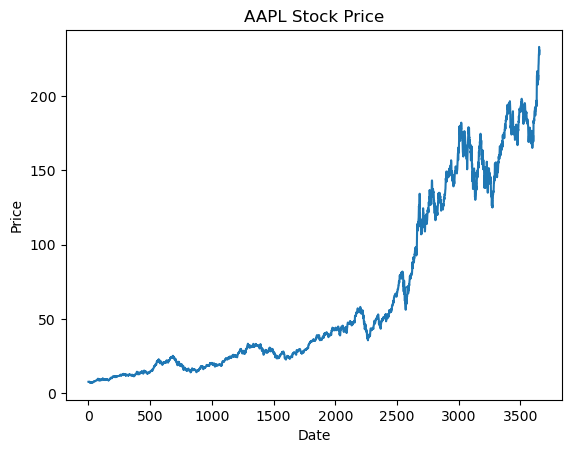

In [81]:
plt.plot(data['Close'])
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# Create test and train data set

In [82]:
X = data.drop(['Close'], axis=1)
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to monthly

In [83]:
display(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [84]:
data['Date'] = pd.to_datetime(data['Date'])

In [85]:
data.set_index('Date', inplace=True)

In [86]:
data_monthly = data.resample('ME').mean()

# Decompose time series into components using additive and multiplicative models

In [87]:
decomposition_additive = seasonal_decompose(data_monthly['Close'], model='additive')
decomposition_multiplicative = seasonal_decompose(data_monthly['Close'], model='multiplicative')

# Univariate Forecasting - Conventional Models/Statistical Models
# Fit a Holt Winters model to the data and forecast for the next year


In [88]:
model_hw = ExponentialSmoothing(data_monthly['Close'], seasonal_periods=12, trend='add', seasonal='add')
model_hw_fit = model_hw.fit()
forecast_hw = model_hw_fit.forecast(steps=12)

# Fit an ARIMA model to the daily data and do a diagnostic check validity of the model

In [89]:
model_arima = ARIMA(data['Close'], order=(1,1,1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3655
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6786.366
Date:                Sun, 14 Jul 2024   AIC                          13578.733
Time:                        19:38:34   BIC                          13597.343
Sample:                             0   HQIC                         13585.360
                               - 3655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4259      0.264      1.613      0.107      -0.092       0.943
ma.L1         -0.4504      0.262     -1.720      0.085      -0.964       0.063
sigma2         2.4027      0.022    108.048      0.0

# Fit a SARIMA model to the daily data

In [90]:
model_sarima = ARIMA(data['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())

C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                 3655
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6796.598
Date:                          Sun, 14 Jul 2024   AIC                          13603.197
Time:                                  19:38:40   BIC                          13634.198
Sample:                                       0   HQIC                         13614.239
                                         - 3655                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4614      0.239      1.929      0.054      -0.007       0.930
ma.L1         -0.4867      0.237     -2.056      0.

# Forecast the series for the next three months

In [91]:
forecast_arima = model_arima_fit.forecast(steps=90)


C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Bala Vignesh.A\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Fit the ARIMA to the monthly series

In [92]:
model_arima_monthly = ARIMA(data_monthly['Close'], order=(1,1,1))
model_arima_monthly_fit = model_arima_monthly.fit()
print(model_arima_monthly_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  175
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -543.648
Date:                Sun, 14 Jul 2024   AIC                           1093.296
Time:                        19:38:40   BIC                           1102.773
Sample:                    01-31-2010   HQIC                          1097.140
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0365      0.131      0.278      0.781      -0.220       0.293
ma.L1          0.3209      0.137      2.343      0.019       0.052       0.589
sigma2        30.2707      2.040     14.837      0.0